In [4]:
# Import necessary libraries
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [5]:
# Define function to load images and labels
def load_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if img_path.endswith(".jpg") or img_path.endswith(".png"):  # assuming images are in jpg or png format
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))  # resize images for CNN input size
            images.append(img)
            labels.append(label)
    return images, labels


In [6]:
# Load infected images
infected_folder = '/content/drive/MyDrive/PROJECT/PIT'
infected_images, infected_labels = load_images(infected_folder, 1)

# Load healthy images
healthy_folder = '/content/drive/MyDrive/PROJECT/PHT'
healthy_images, healthy_labels = load_images(healthy_folder, 0)

In [7]:
# Concatenate infected and healthy images
X = np.concatenate((infected_images, healthy_images), axis=0)
y = np.concatenate((infected_labels, healthy_labels))


In [8]:
# Convert labels to categorical format
y_categorical = np.array(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)


In [9]:
# Create data generators with data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [10]:
# Create data generators for train and test sets
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [11]:
# Add new top layers for classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [12]:
# Freeze base layers of VGG16
base_model.trainable = False

In [13]:
# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [14]:
# Fine-tune the model
history = model.fit(train_generator, epochs=10, validation_data=test_generator)


Epoch 1/10
5/5 [==============================] - 133s 28s/step - loss: 0.8253 - accuracy: 0.4599 - val_loss: 0.6313 - val_accuracy: 0.6000
Epoch 2/10
5/5 [==============================] - 131s 27s/step - loss: 0.7011 - accuracy: 0.5255 - val_loss: 0.5130 - val_accuracy: 0.9143
Epoch 3/10
5/5 [==============================] - 130s 31s/step - loss: 0.5647 - accuracy: 0.7080 - val_loss: 0.4362 - val_accuracy: 0.9429
Epoch 4/10
5/5 [==============================] - 112s 22s/step - loss: 0.5057 - accuracy: 0.7810 - val_loss: 0.3656 - val_accuracy: 0.9429
Epoch 5/10
5/5 [==============================] - 112s 23s/step - loss: 0.4232 - accuracy: 0.8613 - val_loss: 0.3137 - val_accuracy: 0.9429
Epoch 6/10
5/5 [==============================] - 131s 31s/step - loss: 0.3731 - accuracy: 0.9051 - val_loss: 0.2828 - val_accuracy: 0.9429
Epoch 7/10
5/5 [==============================] - 131s 27s/step - loss: 0.3159 - accuracy: 0.9416 - val_loss: 0.2438 - val_accuracy: 0.9429
Epoch 8/10
5/5 [====

In [16]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print("Test Accuracy:", accuracy)

2/2 [==============================] - 23s 2s/step - loss: 0.1768 - accuracy: 0.9429
Test Accuracy: 0.9428571462631226


In [17]:
# Predictions
y_pred = (model.predict(test_generator) > 0.5).astype("int32")

2/2 [==============================] - 23s 2s/step


In [18]:
# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.4857142857142857
Precision: 0.5
Recall: 0.5
F1 Score: 0.5


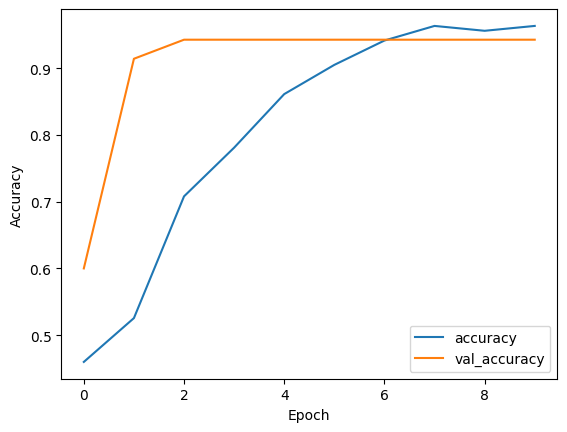

In [19]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

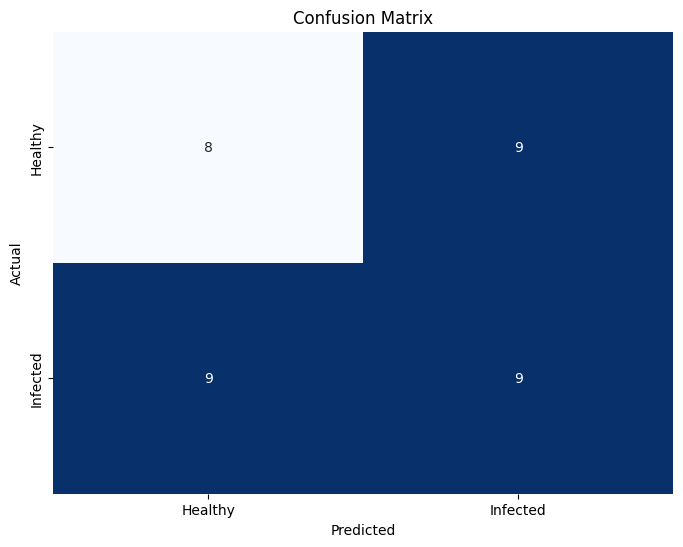

In [20]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Healthy', 'Infected'], yticklabels=['Healthy', 'Infected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()